# **Random Forest Implementation**
*This notebook processes data provided by the [IBM Call for Code Wildfire Challenge](https://community.ibm.com/community/user/datascience/blogs/susan-malaika/2020/11/10/call-for-code-spot-challenge-for-wildfires). The unpreprocessed data is available [on GitHub](https://github.com/Call-for-Code/Spot-Challenge-Wildfires).*

The notebook consists of the following process steps:

*   loading preprocessed data and weather forecast
*   split the data into training, validation and test data
*   normalize data
*   training the model
*   generate predictions on validation data
*   getting feature importances
*   plot result
*   visualization of decision tree


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
import random
import math

from google.colab import drive
from matplotlib import pyplot as plt
from collections import deque

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   loading preprocessed data and weather forecast



In [ ]:
df = pd.read_csv('Cleansed_Data.csv')
forecasts_df = pd.read_csv('HistoricalWeatherForecasts.csv')

df['Date'] = pd.to_datetime(df['Date'])
forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])

df = df.drop(columns=['Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power'], inplace=False)

first_col = df.pop('Estimated_fire_area')
df.insert(0, 'Estimated_fire_area', first_col)

*     normalize Data

In [ ]:
scaler = MinMaxScaler()
for col in df:
  if col not in ['Estimated_fire_area', 'Region', 'Date']:
    df[[col]] = scaler.fit_transform(df[[col]])

*   split the data into training, validation and test data

In [ ]:
#TEST DATA

df = df.set_index('Date', inplace=False)
splitting_date = np.datetime64('2021-01-17T00:00:00.000000000')
test_df = df[(df.index >= splitting_date)]
df = df[(df.index <= splitting_date)] # because the last date only serves for calculation of the deviation, it can be put into the training data 

#VALIDATION AND TRAINING DATA

df = df.sample(n = df.shape[0])
val_df = df.tail(int(len(df)*(10/100)))
train_df = df.head(int(len(df)*(90/100)))

def split_x_and_y(df):
  df_arr = df.copy()
  df_arr.reset_index(inplace=True)
  df_arr.drop(columns=['Region', 'Date'], inplace=True)
  arr = np.asarray(df_arr)
  x = arr[:,1:]
  y = arr[:,0:1].ravel()
  return x,y

train_x, train_y = split_x_and_y(train_df)
val_x, val_y = split_x_and_y(val_df)
test_x, test_y = split_x_and_y(test_df)

*   Random Forest creation based on training data

In [ ]:
rf = RandomForestRegressor(n_estimators = 250, criterion='mse', 
                           max_features='auto', min_samples_leaf=10, 
                           bootstrap=True, max_depth=125, oob_score=True, n_jobs=2)
#rf = RandomForestRegressor(criterion='mse', n_jobs=2)
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=125, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=2, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

*   generate predictions on validation data

In [ ]:
def get_prediction_results(df, x, y):
  predictions = rf.predict(x)

  df_result = df[['Region']].copy()
  df_result.reset_index(inplace=True)
  df_result['PREDICTIONS'] = pd.DataFrame(predictions.reshape(-1, 1), columns=['PREDICTIONS'])
  df_result.insert(value = pd.DataFrame(y.reshape(-1, 1)), column='ACTUAL', loc=3)
  df_result['DIFFERENCE'] = df_result.PREDICTIONS - df_result.ACTUAL
  df_result.dropna(inplace=True)
  #df_result.set_index(['Date','Region'], inplace=True)

  print('ACCURACY RESULTS')
  print('Root Mean Squared Error:',round(math.sqrt(mean_squared_error(np.asarray(df_result.ACTUAL), np.asarray(df_result.PREDICTIONS), squared=False)),2))
  print('R2 Score:',round(r2_score(np.asarray(df_result.ACTUAL), np.asarray(df_result.PREDICTIONS)),2))

  print(df_result.head(5))
  print('...')
  print(df_result.tail(5))
  print('_______________________________')
  df_result.reset_index(inplace=True)
  return df_result

val_result = get_prediction_results(val_df, val_x, val_y)
test_result = get_prediction_results(test_df, test_x, test_y)

ACCURACY RESULTS
Root Mean Squared Error: 6.99
R2 Score: 0.85
        Date Region  PREDICTIONS      ACTUAL  DIFFERENCE
0 2013-07-26     VI     0.080645    0.000000    0.080645
1 2010-06-01    NSW     3.298186    0.000000    3.298186
2 2008-07-17     NT   163.078166  186.296000  -23.217834
3 2012-09-29     NT   284.256151  457.412692 -173.156541
4 2011-12-09     QL   193.046968  457.412692 -264.365724
...
           Date Region  PREDICTIONS      ACTUAL  DIFFERENCE
4096 2015-07-13     NT   288.193727  355.825063  -67.631336
4097 2015-05-09     QL    86.524862  145.413000  -58.888138
4098 2020-03-29    NSW    74.676126    1.430000   73.246126
4099 2016-11-05     NT   276.324970  144.500794  131.824177
4100 2014-03-19     WA   248.690921  346.880513  -98.189592
_______________________________
ACCURACY RESULTS
Root Mean Squared Error: 6.34
R2 Score: -1.0
        Date Region  PREDICTIONS  ACTUAL  DIFFERENCE
0 2021-01-17    NSW    30.032162   5.000   25.032162
1 2021-01-18    NSW    26.850881

*    plot result

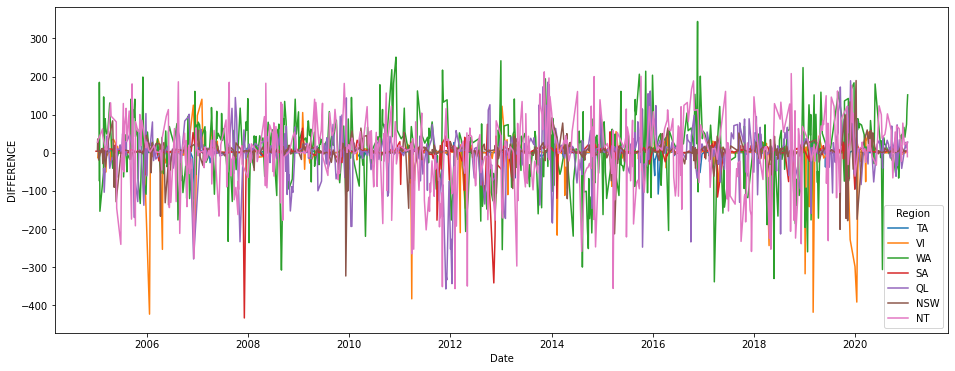

In [ ]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="DIFFERENCE", hue='Region', data=val_result)

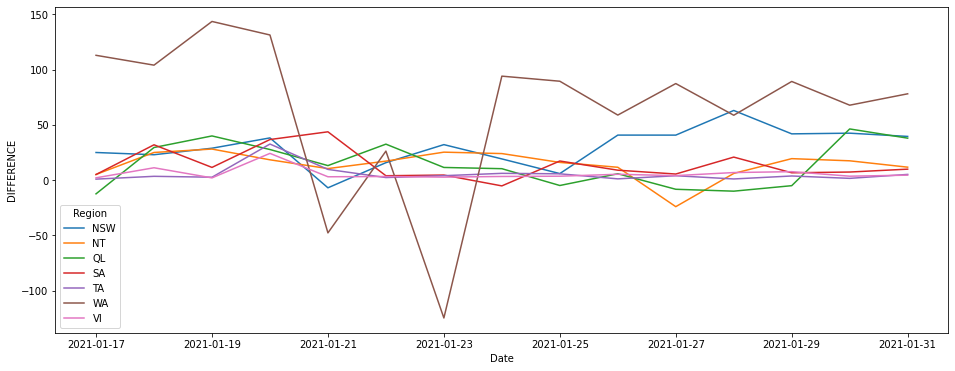

In [ ]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="DIFFERENCE", hue='Region', data=test_result)

*   visualization of decision tree

In [ ]:
from sklearn.tree import export_graphviz
import pydot
feature_names = df.columns

tree = rf.estimators_[5]# Pull out one tree from the forest
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names[:39], rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')


In [ ]:

from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

tree = rf.estimators_[5]

dot_data = export_graphviz(tree,filled=True,rounded=True,class_names=['Setosa','Versicolor','Virginica'], feature_names=feature_names[:39],out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.311743 to fit



True

*   getting feature importances

In [ ]:
features = df.drop(columns=['Estimated_fire_area'], inplace=True)

importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


Variable: Closed forest, deciduous broad leaf_inflame_risk Importance: 0.33
Variable: Precipitation_Variance Importance: 0.13
Variable: RelativeHumidity_Min Importance: 0.1
Variable: Open forest, deciduous broad leaf_inflame_risk Importance: 0.09
Variable: Open forest, unknown definitions_inflame_risk Importance: 0.04
Variable: SoilWaterContent_Variance Importance: 0.03
Variable: SoilWaterContent_Mean Importance: 0.02
Variable: SoilWaterContent_Min Importance: 0.02
Variable: WindSpeed_Variance   Importance: 0.02
Variable: Vegetation_index_max Importance: 0.02
Variable: Vegetation_index_min Importance: 0.02
Variable: Region               Importance: 0.01
Variable: Precipitation_Min    Importance: 0.01
Variable: RelativeHumidity_Max Importance: 0.01
Variable: RelativeHumidity_Mean Importance: 0.01
Variable: RelativeHumidity_Variance Importance: 0.01
Variable: SolarRadiation_Max   Importance: 0.01
Variable: SolarRadiation_Mean  Importance: 0.01
Variable: SolarRadiation_Min   Importance: 0